<a href="https://colab.research.google.com/github/SeanOldenburger/deep-image-retrieval/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports:

In [ ]:
!pip install -Uqq fastbook
import fastbook

In [ ]:
from fastai.vision.all import *
from fastbook import *
import cv2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
import random
from sklearn.feature_extraction.text import TfidfTransformer
from IPython.display import clear_output

## Loading in data:

In [ ]:
# mounting google drive to upload images in
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# path to gt images:
path = "/content/gdrive/My Drive/Colab Notebooks/showcase /oxford5k_data"

# path to all 5000 images:
#path = "/content/gdrive/My Drive/Colab Notebooks/deep image retreival/Oxford5k_Data"

Mounted at /content/gdrive


In [ ]:
# creating a base
Path.BASE_PATH = path
path = Path(path)
path

Path('.')

In [ ]:
# old one dont use
def label_func(fname):
  fname = str(fname).split("/")[-1]
  tmp = fname.split("-")
  if len(tmp) == 1:
    tmp1 = tmp[0].split("_")
    if len(tmp1) == 3:
      name = tmp1[0] + "_" + tmp1[1]
    elif len(tmp1) == 2:
      name = tmp1[0]
  else:
    name = tmp[0]
  return name

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# t = torch.cuda.get_device_properties(0).total_memory
# r = torch.cuda.memory_reserved(0)
# a = torch.cuda.memory_allocated(0)
# print(t, r, a)

print("Using ", device)

Using  cuda


In [ ]:
oxford = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(),
                   get_y=label_func,
                   item_tfms=Resize(244),
                   batch_tfms=aug_transforms())
                   
dset = oxford.datasets(path)
dls = oxford.dataloaders(path, bs=32, device=device)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


## VGG16:

In [67]:
# create new model:
model = models.vgg16_bn(pretrained=True)
model.classifier[5] = Identity()
model.classifier[6] = Identity()
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Update weights by training a model:
# learn = cnn_learner(dls, model, metrics=accuracy) # this one doesnt seem to work, figuring out y currently
learn = Learner(dls, model, metrics=accuracy)
learn.summary()

VGG (Input shape: 32 x 3 x 244 x 244)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 244 x 244 
Conv2d                                    1792       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 122 x 122 
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 122 x 12 
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                      

non-trainable params = 0, this refers to pretrained weights pretty sure

In [ ]:
# learning:
#learn.fit_one_cycle(5, 0.01)
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [ ]:
def train_data(learn, dset):
  # computing features, getting names and images per feature
  train_features = []
  train_names = []
  train_images = []
  for idx, (img, name) in enumerate(dset.train):
    clear_output(wait=True)
    print("Image {} / {}".format(idx+1, len(dset.train)))
    img = cv2.resize(np.array(img), (244, 244), interpolation=cv2.INTER_CUBIC)
    feature = np.array(learn.predict(img)[2])
    train_features.append(feature)
    train_names.append(dset.vocab[name])
    train_images.append(np.array(img).reshape((244,244,3)))

  # converting to numpy arrays
  trn_names = np.array(train_names)
  trn_features = np.array(train_features).reshape((len(train_features),len(train_features[0])))
  trn_images = np.array(train_images)

  # weighting with tfidf
  transformer = TfidfTransformer(smooth_idf=False)
  trn_features = transformer.fit_transform(trn_features).toarray()

  # displaying shapes
  clear_output(wait=True)
  print("Names shape: {} | Features shape: {} | Images shape: {}".format(trn_names.shape, trn_features.shape, trn_images.shape))
  return trn_features, trn_names, trn_images

In [ ]:
def valid_data(learn, dset):
  # computing features, getting names and images per feature
  valid_features = []
  valid_names = []
  valid_images = []
  for idx, (img, name) in enumerate(dset.valid):
    clear_output(wait=True)
    print("Image {} / {}".format(idx+1, len(dset.valid)))
    img = cv2.resize(np.array(img), (244, 244), interpolation=cv2.INTER_CUBIC)
    feature = np.array(learn.predict(img)[2])
    valid_features.append(feature)
    valid_names.append(dset.vocab[name])
    valid_images.append(np.array(img).reshape((244,244,3)))

  # converting to numpy arrays
  val_names = np.array(valid_names)
  val_features = np.array(valid_features).reshape((len(valid_features),len(valid_features[0])))
  val_images = np.array(valid_images)

  # weighting with tfidf
  transformer = TfidfTransformer(smooth_idf=False)
  val_features = transformer.fit_transform(val_features).toarray()

  # displaying shapes 
  clear_output(wait=True)
  print("Names shape: {} | Features shape: {} | Images shape: {}".format(val_names.shape, val_features.shape, val_images.shape))
  return val_features, val_names, val_images

## Image retrieval functions:

In [ ]:
def image_retrieval_k(train_data, test_data, train_names, test_names, train_images_as_array, test_images_as_array, k=20, view_option=0, image_size=(32,32), border_size=20):
    avg_precisions = []
    avg_recalls = []
    precisionsatk = []
    count = 0
    
    for idx, query in enumerate(test_data):
        
        all_precisions = []
        all_recalls = []
        precisions = []
        recalls = []

        # Finding the euclidean distance from the query image and sorting them into index
        query = query.reshape((1, -1))
        D = euclidean_distances(train_data, query).squeeze()
        index = np.argsort(D)
        
        # Finding the index of the last correct image in the sorted index to iter to
        last_correct_image_idx = 0
        for i in range(len(index)):
            if train_names[index[i]] == test_names[idx]:
                last_correct_image_idx = i
        
        # make sure we iter to k (for precision@k) if all correct images are found before k
        if k > last_correct_image_idx:
            last_correct_image_idx = k+1
        
        # Itering through all images untill we get to k or last correct image to compute AP
        for kk in range(1, last_correct_image_idx+2):
            TP = 0
            FP = 0
            FN = 0
            
            # Finding the correct amount of images in the training set
            correct_count = 0
            for ind in index:
                if train_names[ind] == test_names[idx]:
                    correct_count += 1
            sized_index = index[:kk]
            
            # Find TP FP FN
            for ind in sized_index:
                if train_names[ind] == test_names[idx]:
                    TP += 1
                else:
                    FP += 1
            FN = correct_count - TP
            
            # If we want to view the images then we run this code, else its a waste of computational time
            if view_option == 1:
                # Creating image of k images (including query image at start)
                tmp = [query.reshape(image_size)]
                for ind in sized_index[:k]:
                    tmp.append(train_data[ind].reshape(image_size))
                output = np.array(tmp)*255
                output = output.transpose(1, 0, 2)
                output = output.reshape((image_size[0], -1))
                im_query = Image.fromarray(output)
            
            # If the last k image is a correct image we add precision to the list
            if train_names[sized_index[-1]] == test_names[idx]:
                precisions.append(TP/(TP+FP))
                recalls.append(TP/(TP+FN))

            # Adding all precisions and recalls to a seperate list
            all_precisions.append(TP/(TP+FP))
            all_recalls.append(TP/(TP+FN))
        
     
        # Solving AP, AR and precision@k
        avg_precisions.append(np.average(precisions))
        avg_recalls.append(np.average(all_recalls))
        precisionsatk.append(all_precisions[k-1])
        
        # Set a viewing option, if 1 we print out the following:
        if view_option == 1:
            display(im_query) 
            print("Label: {}".format(test_names[idx]))
            print("Average Precision for query {}: ".format(idx), avg_precisions[-1])
            print("Precision@k for query {}: ".format(idx), precisionsatk[-1])
            print("\n")
        elif view_option == 0:
            count += 1 
            print("Percentage Complete: {}".format(round((count/len(test_data))*100),2), end="\r")
        elif view_option == 2:
            # Allowing a view_option 2 -> for viewing top k images from non_pixel value inputs
            # creating an array of the top k similar images
            top_k_images = [test_images_as_array[idx]]
            for i in range(0,k):
                top_k_images.append(train_images_as_array[index[i]])

            fig, axes = plt.subplots(1, k+1, figsize=(200/k, 200/k))
            for i, (image, ax) in enumerate(zip(top_k_images, axes.ravel())):
                # resize image if border size greater than 10:
                if border_size >= 10:
                    image = cv2.resize(image, (250, 400), interpolation=cv2.INTER_CUBIC)
                if i == 0:
                    query_name = test_names[idx]
                    title = "Query: {}".format(query_name)
                    color = (0, 255, 0)
                    image = border(image, color, border_size)
                else:
                    title = train_names[sized_index[i-1]]
                    if train_names[sized_index[i-1]] == query_name:
                        color = (0, 255, 0)
                        image = border(image, color, border_size)
                    else:
                        color = (255, 0, 0)
                        image = border(image, color, border_size)
                # display all set options
                ax.imshow(image, cmap="gray")
                ax.set_title(title)
                ax.axis("off")
            plt.show()
            print("Label: {}".format(test_names[idx]))
            print("Average Precision for query {}: ".format(idx), avg_precisions[-1])
            print("Precision@k for query {}: ".format(idx), precisionsatk[-1])
            print("\n")
        elif view_option == 3:
            top_k_images = [test_images_as_array[idx]]
            for i in range(0,k):
                top_k_images.append(train_images_as_array[index[i]])

            fig, axes = plt.subplots(1, k+1, figsize=(200/k, 200/k))
            for i, (image, ax) in enumerate(zip(top_k_images, axes.ravel())):
                # convert image to RGB and add border:
                # resize image if border size greater than 10:
                if border_size >= 10:
                    image = cv2.resize(image, (250, 400), interpolation=cv2.INTER_CUBIC)
                if i == 0:
                    query_name = test_names[idx]
                    title = "Query: {}".format(query_name)
                else:
                    title = train_names[sized_index[i-1]]
                    if train_names[sized_index[i-1]] == query_name:
                        color = (0, 255, 0)
                        image = border(image, color, border_size)
                    else:
                        color = (255, 0, 0)
                        image = border(image, color, border_size)
                # display all set options
                ax.imshow(image, cmap="gray")
                ax.set_title(title)
                ax.axis("off")
            plt.show()
    return avg_precisions, avg_recalls, precisionsatk

In [ ]:
def border(img, color, border_size):
    # get dimensions
    h, w = img.shape[:2]

    # make a base slightly bigger than image
    base_size= h+(border_size*2), w+(border_size*2), 3
    base = np.zeros(base_size, dtype=np.uint8)

    # make a boundary of chosen color
    cv2.rectangle(base, (0,0), (w+20,h+20), color, 30)

    # put original image into base
    base[border_size:h+border_size, border_size:w+border_size] = img
    
    return base

## Retreival:


In [ ]:
# loading in training data
trn_features, trn_names, trn_images = train_data(learn, dset)

Image 248 / 567


IndexError: ignored

In [ ]:
# loading in validation data
val_features, val_names, val_images = valid_data(learn, dset)

In [ ]:
k = 10
view_option = 2
border_size = 3

AP, AR, precisionsatk = image_retrieval_k(trn_features, val_features, trn_names, val_names, trn_images, val_images, k, view_option, border_size)

In [ ]:
mAP = np.mean(AP)
mAP

0.9424901750597379

Good/ok images:
- pretrained with 11 outputs (fit one cycle) -> mAP = 0.889, 0.805, 0.875, 0.895
- " " (fine tune) -> mAP = 0.942

5k images:
- pretrained with 17 outputs -> mAP = 0.236
- many labelled incorrectly, many labeled oxford, that is very general and doesnt belong to a class -> refer to ground truth files and include junk images for correct labelling with larger dataset then the good/ok
- it finds images based on classification label, not information similarity in the image ( use a different architecture)

## Saving:

In [ ]:
# save features:
np.save("/content/gdrive/My Drive/Colab Notebooks/deep image retreival/VGG/train_features_(finetune)", trn_features)
np.save("/content/gdrive/My Drive/Colab Notebooks/deep image retreival/VGG/valid_features_(finetune)", val_features)

## Loading:

In [ ]:
train_path = "/content/gdrive/My Drive/Colab Notebooks/deep image retreival/VGG/train_features.npy"
query_path = "/content/gdrive/My Drive/Colab Notebooks/deep image retreival/VGG/valid_features.npy"

def load_from_npy(dset, train_path, query_path):
  train_data = np.load(train_path)
  queries = np.load(query_path)

  train_names = []
  query_names = []
  for idx, (x, y) in enumerate(dset.train):
    print(idx, "/", len(dset.train))
    train_names.append(dset.vocab[y])
  for idx, (x, y) in enumerate(dset.valid):
    print(idx, "/", len(dset.valid))
    query_names.append(dset.vocab[y])

  train_names = np.array(train_names)
  query_names = np.array(query_names)
  print("Train Names: {} | Query Names: {} | Train Data: {} | Query Data: {}".format(train_names.shape, query_names.shape, train_data.shape, queries.shape))

  return train_names, query_names, train_data, queries

## Visualization:

In [ ]:
def tSNE(filenames, features):
    # create tsne
    tsne = TSNE(random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # convert names to integers for graphing function:
    sorted_names = sorted(filenames)
    names = []
    y = []
    counter = []
    count = -1
    start = 0
    for i in sorted_names:
        if i not in names:
            counter.append(start)
            start = 0
            names.append(i)
            count += 1
        start += 1
        y.append(count)
    counter.append(start)

    # setting colours:
    colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525", "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E", "blue"]
    if len(names) > len(colors)+1:
      # setting colours:
      colors = []
      for i in range(len(y)+1):
        r = random.random()
        b = random.random()
        g = random.random()
        colors.append((r, g, b))
      

    # Plot output:
    plt.figure(figsize=(10, 10))
    plt.xlim(X_tsne[:, 0].min(), X_tsne[:, 0].max() + 1)
    plt.ylim(X_tsne[:, 1].min(), X_tsne[:, 1].max() + 1)

    for i in range(len(X_tsne)):
        plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y[i]), color = colors[y[i]], fontdict={'weight': 'bold', 'size': 9})

    plt.title("t-SNE for Oxford5k ")

    plt.ylabel("t-SNE feature 0")
    plt.xlabel("t-SNE feature 1")
    plt.show()
    
    # print information relating to plot:
    print(f'{"NAME":<20s} {"NUMBER":<10s} {"COUNT":<5s}')
    for idx, name, count in zip(range(len(names)), names, counter[1:]):
        print(f'{name:<20s} {str(idx):<10s} {str(count):<5s}')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


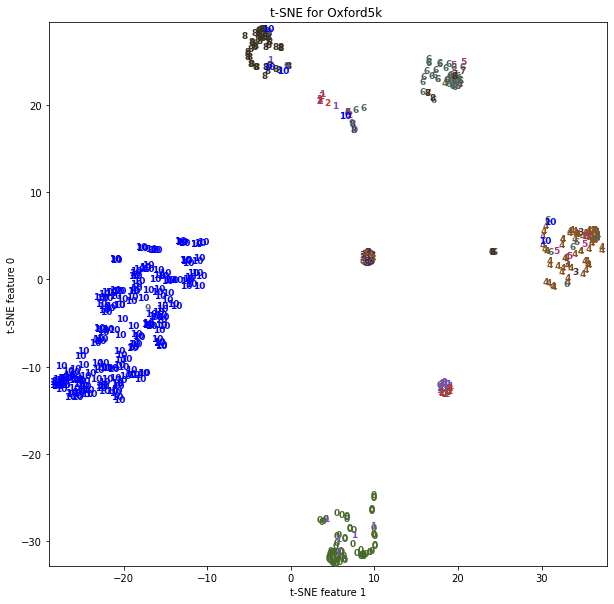

NAME                 NUMBER     COUNT
all_souls            0          78   
ashmolean            1          25   
balliol              2          12   
bodleian             3          24   
christ_church        4          78   
cornmarket           5          9    
hertford             6          54   
keble                7          7    
magdalen             8          54   
pitt_rivers          9          6    
radcliffe_camera     10         220  


In [ ]:
# visualizing training data:
tSNE(trn_names, trn_features)

In [ ]:
# visualization for a given query image:
def visualize_query(query, query_name, train_data, train_names, k):
  # Finding the euclidean distance from the query image and sorting them into index
  query = query.reshape((1, -1))
  D = euclidean_distances(train_data, query).squeeze()
  index = np.argsort(D)

  # grab only the k closest points
  data = []
  name = []
  for idx in index[:k]:
    data.append(train_data[idx])
    name.append(train_names[idx])
  
  joined_data = concat(query.reshape((1,query.shape[1])), data)
  # create tsne
  tsne = TSNE(random_state=42)
  joined_tsne = tsne.fit_transform(joined_data)

  X_tsne = joined_tsne[1:]
  query_tsne = joined_tsne[:1]
  
  # convert names to integers for graphing function:
  sorted_names = sorted(name)
  names = []
  y = []
  counter = []
  count = -1
  start = 0
  for i in sorted_names:
      if i not in names:
          counter.append(start)
          start = 0
          names.append(i)
          count += 1
      start += 1
      y.append(count)
  counter.append(start)

  # setting colours:
  colors = []
  for i in range(len(y)+1):
    r = random.random()
    b = random.random()
    g = random.random()
    colors.append((r, g, b))


  # Plot output:
  plt.figure(figsize=(10, 10))
  if X_tsne[:, 0].min() < 0:
    x = 1.5
  else:
    x=-1.5
  if X_tsne[:, 1].min() < 0:
    xx = 1.5
  else:
    xx = -1.5
  plt.xlim(X_tsne[:, 0].min()*x, X_tsne[:, 0].max()*1.5)
  plt.ylim(X_tsne[:, 1].min()*xx, X_tsne[:, 1].max()*1.5)

  for i in range(len(X_tsne)):
      plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y[i]), color = colors[y[i]], fontdict={'weight': 'bold', 'size': 9})

  plt.text(query_tsne[0, 0], query_tsne[0, 1], ".", color=(1,0,0), fontdict={'weight': 'bold', 'size': 50})
  plt.title("t-SNE for Oxford5k for k = {}".format(k))
  plt.ylabel("t-SNE feature 0")
  plt.xlabel("t-SNE feature 1")
  plt.show()

  # print information relating to plot:
  print("Query Image: {} | Red Square\n".format(query_name))

  print(f'{"NAME":<20s} {"NUMBER":<10s} {"COUNT":<5s}')
  for idx, name, count in zip(range(len(names)), names, counter[1:]):
      print(f'{name:<20s} {str(idx):<10s} {str(count):<5s}')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


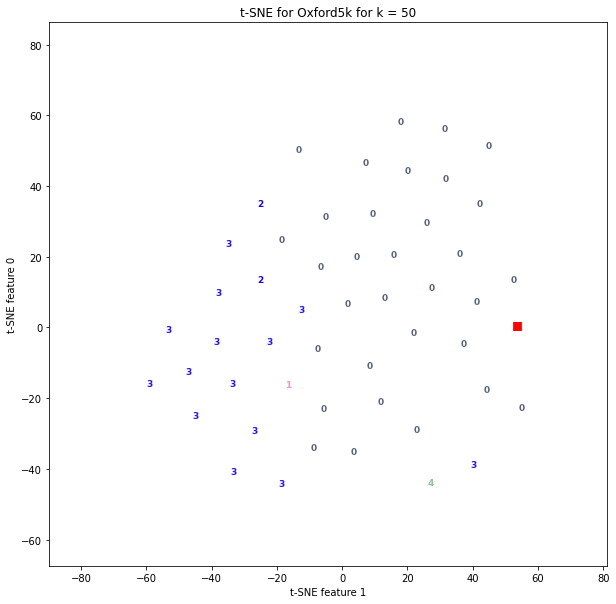

Query Image: all_souls | Red Square

NAME                 NUMBER     COUNT
all_souls            0          32   
christ_church        1          1    
magdalen             2          2    
oxford               3          14   
radcliffe_camera     4          1    


In [ ]:
visualize_query(val_features[2], val_names[2], trn_features, trn_names, k=50)